In [1]:
!git clone https://github.com/egemenokte/3DLayeredElastic.git
%cd 3DLayeredElastic/Run
import sys
import os
sys.path.append('..')
from Main.MLEV_Parallel import PyMastic
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
import random

import sys
import os


fatal: destination path '3DLayeredElastic' already exists and is not an empty directory.
/home/ugiridharan_umass_edu/3DLayeredElastic/Run


/home/ugiridharan_umass_edu/.local/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import pickle
import torch
import json
import time
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error
import torch
import matplotlib.pyplot as plt
import numpy as np
import logging
import os
import seaborn as sns
import torch.nn as nn
import copy
from torch import nn

from torch.nn import Linear, ReLU,Tanh
from torch_geometric.nn import GCNConv, GATConv
import torch.nn.functional as F

In [3]:
# Read dictionary pkl file
with open('/work/pi_eokte_umass_edu/Urja/Frame_data_1000_new_modified.pkl', 'rb') as fp:
    FrameLarge = pickle.load(fp)
with open('/work/pi_eokte_umass_edu/Urja/Section_data_1000_new_modified.pkl', 'rb') as fp:
    Section = pickle.load(fp)

In [4]:
Nmaterial=3#maximum number of materials (AC, base, subbase, subgrade)
MaterialType=['AC','B','SG'] #AC, base, subbase, subgrade
Sublayermax=[1,1,1] #each material can have up to 5 sublayers, excluding subgrade

#################May need to change
# Thicknessrange=[[2,20],[4,40],[4,40]] #thickness range in inches
# Modulusrange=[[200,2000],[20,300],[20,300],[5,50]] #modulus range in ksi

Thicknessrange=[[2,20],[4,40]] #thickness range in inches
Modulusrange=[[500,2000],[50,300],[5,50]] #modulus range in ksi
N=1000 #Number of points
zpoints=14 #how many points to generate along z
xpoints=10 #how many points to generate along x
seed=42
############################


Thicknessincrement=[1,2,4]
ModulusIncrement=[50,20,20,5]# increment in modulus sampling
# nurange=[[0,0.499],[0.15,0.499],[0.15,0.499],[0.15,0.499],[0.4,0.499]] #poissons ratio
# nurange=[[0.3,0.4],[0.2,0.499],[0.2,0.499],[0.2,0.499],[0.2,0.499]] #poissons ratio
nurange=[[0.3,0.4],[0.2,0.499],[0.2,0.499]] #poissons ratio
#xmax=40 #40 inches away from the load
#rmax=80 #80 inches away from the load
#LoadRange=[1000,20000] #pounds of force applied
arange=[3,9] #contact radius (in)
arange=[4,4] #contact radius (in)

apoints=2 #how many contact radii to analyze
apoints=1 #how many contact radii to analyze
factor=0.4
filter = 2
split_idx=800
test_idx=900


In [5]:

Length= FrameLarge["Structure"].unique()

for structure in Length:
    struct = int(structure) - 1
    
    filtered = FrameLarge[FrameLarge["Structure"] == structure]

    inp = filtered.loc[:, ["Strain_Z"]] * 1e6

    # Check if any Strain_Z value is greater than 2000
    if (inp['Strain_Z'] >=1500).any():
       
        FrameLarge = FrameLarge[FrameLarge["Structure"] != structure]
        print(struct)
        continue 
   

111
215
223
335
352
633
658
663
898
992


In [6]:
Length= FrameLarge["Structure"].unique()


In [7]:
Length[test_idx:]

array([ 910.,  911.,  912.,  913.,  914.,  915.,  916.,  917.,  918.,
        919.,  920.,  921.,  922.,  923.,  924.,  925.,  926.,  927.,
        928.,  929.,  930.,  931.,  932.,  933.,  934.,  935.,  936.,
        937.,  938.,  939.,  940.,  941.,  942.,  943.,  944.,  945.,
        946.,  947.,  948.,  949.,  950.,  951.,  952.,  953.,  954.,
        955.,  956.,  957.,  958.,  959.,  960.,  961.,  962.,  963.,
        964.,  965.,  966.,  967.,  968.,  969.,  970.,  971.,  972.,
        973.,  974.,  975.,  976.,  977.,  978.,  979.,  980.,  981.,
        982.,  983.,  984.,  985.,  986.,  987.,  988.,  989.,  990.,
        991.,  992.,  994.,  995.,  996.,  997.,  998.,  999., 1000.])

In [8]:
Section[913]

{'Material': ['AC', 'B', 'SG'],
 'Thickness': array([12, 10]),
 'Poisson': array([0.4 , 0.3 , 0.25]),
 'MaterialSub': ['AC', 'B', 'SG'],
 'ThicknessSub': array([12., 10.]),
 'PoissonSub': array([0.4 , 0.3 , 0.25]),
 'ModulusSub': array([650,  50,  10]),
 'z': array([ 0.42044821,  0.921812  ,  1.67383577,  2.70844676,  4.05429077,
         5.73757874,  7.78262075, 10.21218895, 11.99      , 12.01      ,
        13.04777757, 16.30979697, 20.01772293, 21.99      , 22.01      ,
        24.19021453, 28.84520908, 34.        ]),
 'x': array([ 0.5       ,  0.96021096,  1.56925807,  2.32714132,  3.23386073,
         4.28941629,  5.49380799,  6.84703584,  8.34909985, 10.        ]),
 'a': [4],
 'Response': {0: {'Displacement_Z': array([[0.00469273, 0.00467119, 0.00462377, 0.00454009, 0.00441702,
           0.00426568, 0.00411251, 0.00398648, 0.0038952 , 0.00381601],
          [0.00466196, 0.00464225, 0.00459882, 0.00452202, 0.00440856,
           0.00426777, 0.00412277, 0.00399946, 0.00390588, 0.0

In [9]:
FrameLarge[FrameLarge["Structure"]==1000]

,Structure,Pressure,ContactRadius,z,r,H1,H2,E1,E2,E3,...,nu3,Displacement_Z,Displacement_H,Stress_Z,Stress_R,Stress_T,Stress_RZ,Strain_Z,Strain_R,Strain_T
169640,1000.0,80.0,4.0,0.420448,0.500000,12.0,0.0,1850.0,0.0,50.0,...,0.2,0.001344,-0.000003,105.935637,92.123919,92.105020,2.238406,0.000017,0.000007,0.000007
169641,1000.0,80.0,4.0,0.420448,0.960211,12.0,0.0,1850.0,0.0,50.0,...,0.2,0.001336,-0.000007,101.658687,89.411105,89.344010,4.176177,0.000016,0.000007,0.000007
169642,1000.0,80.0,4.0,0.420448,1.569258,12.0,0.0,1850.0,0.0,50.0,...,0.2,0.001319,-0.000011,92.327131,83.475719,83.312252,6.381503,0.000014,0.000007,0.000007
169643,1000.0,80.0,4.0,0.420448,2.327141,12.0,0.0,1850.0,0.0,50.0,...,0.2,0.001290,-0.000016,76.187424,73.143811,72.848481,8.289330,0.000010,0.000007,0.000007
169644,1000.0,80.0,4.0,0.420448,3.233861,12.0,0.0,1850.0,0.0,50.0,...,0.2,0.001246,-0.000023,53.422792,58.362030,57.988618,9.079479,0.000004,0.000007,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169795,1000.0,80.0,4.0,24.000000,4.289416,12.0,0.0,1850.0,0.0,50.0,...,0.2,0.000821,0.000020,0.846403,-0.073937,-0.082265,0.083854,0.000018,-0.000005,-0.000005
169796,1000.0,80.0,4.0,24.000000,5.493808,12.0,0.0,1850.0,0.0,50.0,...,0.2,0.000817,0.000026,0.831717,-0.067537,-0.080773,0.104901,0.000017,-0.000004,-0.000005
169797,1000.0,80.0,4.0,24.000000,6.847036,12.0,0.0,1850.0,0.0,50.0,...,0.2,0.000811,0.000031,0.811868,-0.059067,-0.078749,0.126571,0.000017,-0.000004,-0.000005
169798,1000.0,80.0,4.0,24.000000,8.349100,12.0,0.0,1850.0,0.0,50.0,...,0.2,0.000803,0.000037,0.786407,-0.048515,-0.076145,0.147899,0.000016,-0.000004,-0.000004


In [10]:
FrameLarge.iloc[:135520,19:22]

,Strain_Z,Strain_R,Strain_T
0,2.531674e-05,0.000077,7.787417e-05
1,2.257008e-05,0.000076,7.730536e-05
2,1.661692e-05,0.000072,7.602813e-05
3,6.473691e-06,0.000065,7.368004e-05
4,-7.371352e-06,0.000055,6.995397e-05
...,...,...,...
136795,3.274087e-05,0.000003,-1.423299e-05
136796,1.360695e-05,0.000010,-9.544768e-06
136797,3.404155e-06,0.000011,-5.402335e-06
136798,3.574062e-07,0.000009,-2.581838e-06


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
x_train,y_train=FrameLarge.iloc[:135520,3:13],FrameLarge.iloc[:135520,19:22]
x_val,y_val = FrameLarge.iloc[135520:152720,3:13],FrameLarge.iloc[135520:152720,19:22]
# X_train,X_test,y_train,Y_test = train_test_split(FrameLarge.iloc[:,3:13],FrameLarge.iloc[:,19:20], test_size=0.1, random_state=42)
X_test, Y_test = FrameLarge.iloc[152720:169799,3:13], FrameLarge.iloc[152720:169799,19:22]
scaler = StandardScaler()
scalery = StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(X_test)
x_val=scaler.transform(x_val)
y_train=scalery.fit_transform(y_train)
y_val=scalery.transform(y_val)

y_test=scalery.transform(Y_test)

print(y_val.min(), y_val.max())

-5.839728435373476 10.101204249752342


In [10]:
# Assuming x_train and y_train are NumPy arrays
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# # Convert data to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
x_train.shape

(135520, 10)

In [11]:
# Define the model class
class MyModel(nn.Module):
    def __init__(self, input_size, l1_lambda=1e-5):
        super(MyModel, self).__init__()
        self.l1_lambda = l1_lambda
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 3)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        x = self.act(self.fc4(x))
        x = self.fc5(x)
        return x

    def l1_regularization(self):
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        return self.l1_lambda * l1_norm

In [12]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from sklearn.model_selection import train_test_split
# import numpy as np
# from torch.utils.data import DataLoader, TensorDataset



# # Create DataLoader for batching
# batch_size = 1024
# train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# # Define the model class
# class MyModel(nn.Module):
#     def __init__(self, input_size, l1_lambda=1e-5):
#         super(MyModel, self).__init__()
#         self.l1_lambda = l1_lambda
#         self.fc1 = nn.Linear(input_size, 64)
#         self.fc2 = nn.Linear(64, 64)
#         self.fc3 = nn.Linear(64, 64)
#         self.fc4 = nn.Linear(64, 64)
#         self.fc5 = nn.Linear(64, 3)
#         self.act = nn.ReLU()

#     def forward(self, x):
#         x = self.act(self.fc1(x))
#         x = self.act(self.fc2(x))
#         x = self.act(self.fc3(x))
#         x = self.act(self.fc4(x))
#         x = self.fc5(x)
#         return x

#     def l1_regularization(self):
#         l1_norm = sum(p.abs().sum() for p in model.parameters())
#         return self.l1_lambda * l1_norm

# # Instantiate the model
# input_size = x_train.shape[1]
# model = MyModel(input_size)
# train_losses=[]
# val_losses=[]
# # Define the loss function and optimizer
# # criterion = nn.MSELoss()
# criterion = nn.L1Loss()
# optimizer = optim.Adam(model.parameters(),lr=0.01)

# # Training step
# num_epochs = 400

# for epoch in range(num_epochs):
#     model.train()
#     epoch_avg_loss = []
    
#     # Iterate through batches
#     for batch_x, batch_y in train_loader:
#         # Forward pass
#         outputs = model(batch_x)
#         # if epoch == 19:
#             # print(batch_x.min(), batch_x.max())
#             # print("pred", outputs.min(), outputs.max(), outputs.mean())
#             # print("label", batch_y.min(), batch_y.max(), batch_y.mean())
#         loss = criterion(outputs, batch_y)
#         # print(loss)
        

#         # Add L1 regularization
#         # l1_loss = model.l1_regularization()
#         # loss = loss + l1_loss
#         # print(loss.item(), l1_loss.item())

#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         train_losses.append(loss.item())
#         epoch_avg_loss.append(loss.item())

#     # Calculate validation loss
#     model.eval()
#     with torch.no_grad():
#         val_outputs = model(x_val_tensor)
#         val_loss = criterion(val_outputs, y_val_tensor)
#         val_losses.append(val_loss.item())
    
#     # Print training and validation loss
#     # print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")
#     print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {sum(epoch_avg_loss)/len(epoch_avg_loss):.4f}, Validation Loss: {val_loss.item():.4f}")


In [13]:
# Instantiate the model
input_size = x_train.shape[1]
model = MyModel(input_size)

In [14]:
path = '/work/pi_eokte_umass_edu/Urja/model.pth'

# Save the model
# torch.save(model.state_dict(), path)

In [15]:
model.load_state_dict(torch.load(path))

# Set the model to evaluation mode (optional if you are only evaluating the model)
model.eval()

/tmp/ipykernel_587877/3597792548.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


MyModel(
  (fc1): Linear(in_features=10, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=3, bias=True)
  (act): ReLU()
)

In [16]:
train_steps_per_epoch = len(train_loader)
total_epochs=400
# Calculate average training loss per epoch
train_losses_per_epoch = [
    sum(train_losses[i * train_steps_per_epoch:(i + 1) * train_steps_per_epoch]) / train_steps_per_epoch
    for i in range(total_epochs)
]

# Plotting training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, total_epochs + 1), train_losses_per_epoch, label='Training Loss')
plt.plot(range(1, total_epochs + 1), val_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

NameError: name 'train_loader' is not defined

In [17]:
model.eval()
device = torch.device('cpu')
model.to(device)  # Move the model to CPU

# Ensure the input
# s are also on the CPU
test_inputs = x_test
# Forward pass to get predictions
with torch.no_grad():
    test_inputs = torch.tensor(x_test,dtype=torch.float32)


test_outputs = model(test_inputs)


# Convert predictions to numpy array
predicted_values = test_outputs.detach().numpy()

In [18]:
y_pred=scalery.inverse_transform(predicted_values)
y_plot=scalery.inverse_transform(y_test)


In [19]:
final_y_plot = y_plot*1e6
final_y_pred = y_pred*1e6

In [20]:
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error


In [21]:
mse_z = mean_squared_error( final_y_plot[:, 0], final_y_pred[:, 0])
mse_r = mean_squared_error( final_y_plot[:, 1], final_y_pred[:, 1])
mse_t = mean_squared_error(  final_y_plot[:, 2], final_y_pred[:, 2])
mae_z = mean_absolute_error( final_y_plot[:, 0], final_y_pred[:, 0])
mae_r = mean_absolute_error(final_y_plot[:, 1], final_y_pred[:, 1])
mae_t = mean_absolute_error(final_y_plot[:, 2], final_y_pred[:, 2])

# mape_z = mean_absolute_percentage_error(batched_graph_test.y[:, 0].cpu().detach().numpy(), predicted_values[:, 0])
# mape_r = mean_absolute_percentage_error(batched_graph_test.y[:, 1].cpu().detach().numpy(), predicted_values[:, 1])
# mape_t = mean_absolute_percentage_error(batched_graph_test.y[:, 2].cpu().detach().numpy(), predicted_values[:, 2])


In [34]:
mae_r

0.9372502983024377

In [23]:

with open('/home/ugiridharan_umass_edu/GNN_training/ZS_test', 'rb') as fp:
    ZS_new = pickle.load(fp)

In [24]:

with open('/home/ugiridharan_umass_edu/GNN_training/xs', 'rb') as fp:
    xs = pickle.load(fp)

In [25]:
import pickle
with open('/home/ugiridharan_umass_edu/GNN_training/batched_graph_test.pkl', 'rb') as fp:
    batched_graph_test = pickle.load(fp)

In [26]:
xs_converted= xs*2.54
ZS_converted = [i*2.54 for i in ZS_new]

In [27]:
xs=np.round(xs_converted,2)
ZS_new=[np.round(zs,2) for zs in ZS_converted]

In [30]:
pred_graph ={}
current_index = 0
for i in range(batched_graph_test.batch_size):
    res_test= len(batched_graph_test[i].y)
    
    pred_values = final_y_pred[current_index:current_index+res_test]
    
    pred_graph[i]=pred_values
    current_index+=res_test
    
    

<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_587877/371906312.py:10: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Actual $\mu\epsilon_z$', fontsize=12)
/tmp/ipykernel_587877/371906312.py:11: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Predicted $\mu\epsilon_z$', fontsize=12)
/tmp/ipykernel_587877/371906312.py:12: SyntaxWarning: invalid escape sequence '\m'
  plt.title('Actual vs Predicted in $\mu\epsilon_z$', fontsize=12)


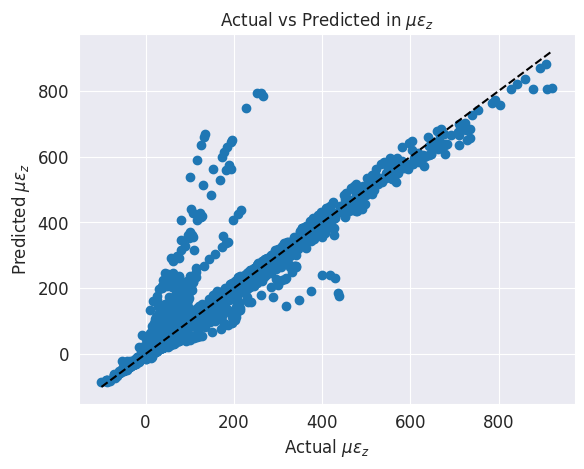

In [31]:

plot_dir='/home/ugiridharan_umass_edu/GNN_training'
sns.set_style("darkgrid")

stress_z = final_y_plot[:, 0]

plt.scatter(stress_z, final_y_pred[:, 0])
p1= max(max(stress_z), max(stress_z))
p2=min(min(stress_z), min(stress_z))
plt.plot([p2,p1],[p2,p1],color='black', linestyle='--')
plt.xlabel('Actual $\mu\epsilon_z$', fontsize=12)
plt.ylabel('Predicted $\mu\epsilon_z$', fontsize=12)
plt.title('Actual vs Predicted in $\mu\epsilon_z$', fontsize=12)

# Set tick parameters with font size 12 pt
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()
plt.close() 


In [29]:
final_y_pred 

array([[11.838822 , -7.3722506, -7.691152 ],
       [11.920262 , -7.292997 , -7.6093173],
       [12.001724 , -7.1855597, -7.498637 ],
       ...,
       [16.937723 , -4.4348607, -4.946054 ],
       [16.200705 , -3.91304  , -4.8801885],
       [15.4758415, -3.5858011, -4.73454  ]], dtype=float32)

<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:30: SyntaxWarning: invalid escape sequence '\m'
<>:31: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:30: SyntaxWarning: invalid escape sequence '\m'
<>:31: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_791033/691733515.py:9: SyntaxWarning: invalid escape sequence '\m'
  plt.scatter(stress_r, final_y_pred[:, 1], color='blue', label='$\mu\epsilon_r$ (r)')
/tmp/ipykernel_791033/691733515.py:12: SyntaxWarning: invalid escape sequence '\m'
  plt.scatter(stress_t, final_y_pred[:, 2], color='orange', label='$\mu\epsilon_t$ (t)')
/tmp/ipykernel_791033/691733515.py:29: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Actual Strain ($\mu\epsilon$)', fontsize=12)
/tmp/ipyk

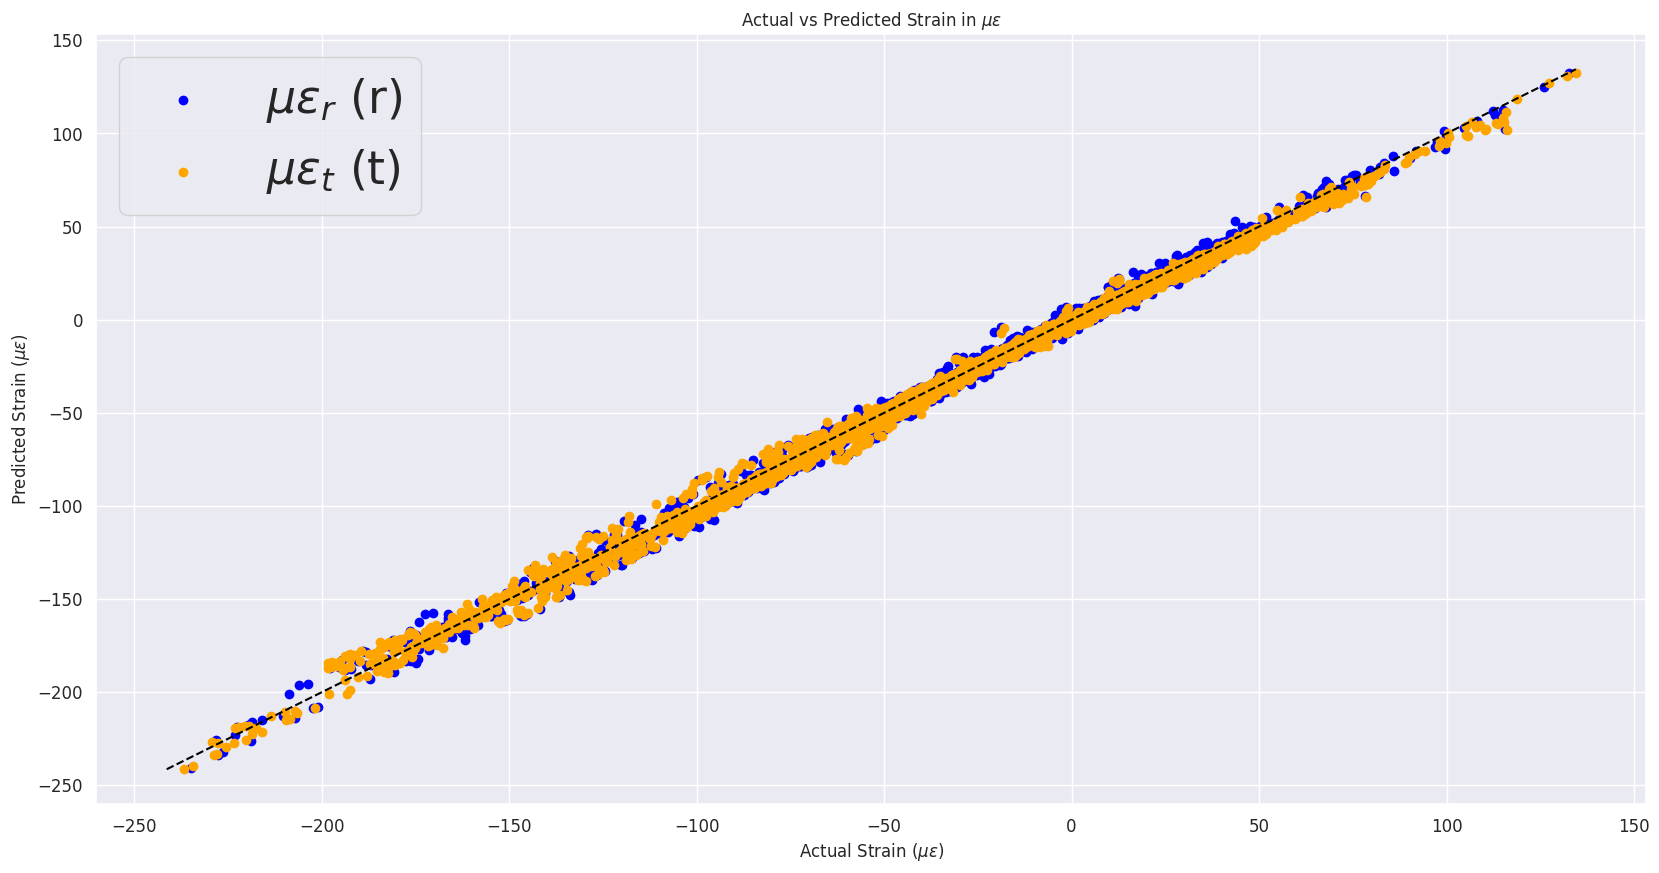

In [41]:
import matplotlib.pyplot as plt
import os

# Plot for both 'r' and 't'
stress_r = final_y_plot[:, 1]
stress_t = final_y_plot[:, 2]

# Scatter plot for r (blue)
plt.scatter(stress_r, final_y_pred[:, 1], color='blue', label='$\mu\epsilon_r$ (r)')

# Scatter plot for t (orange)
plt.scatter(stress_t, final_y_pred[:, 2], color='orange', label='$\mu\epsilon_t$ (t)')

# Define the plot limits for the lines
p1_r = max(max(stress_r), max(final_y_pred[:, 1]))
p2_r = min(min(stress_r), min(final_y_pred[:, 1]))

p1_t = max(max(stress_t), max(final_y_pred[:, 2]))
p2_t = min(min(stress_t), min(final_y_pred[:, 2]))

# Taking the global min and max for combined plots
p1 = max(p1_r, p1_t)
p2 = min(p2_r, p2_t)

# Plot the diagonal line
plt.plot([p2, p1], [p2, p1], color='black', linestyle='--')

# Set labels and title
plt.xlabel('Actual Strain ($\mu\epsilon$)', fontsize=12)
plt.ylabel('Predicted Strain ($\mu\epsilon$)', fontsize=12)
plt.title('Actual vs Predicted Strain in $\mu\epsilon$', fontsize=12)

# Add a legend
plt.legend()

# Set tick parameters with font size 12 pt
plt.tick_params(axis='both', which='major', labelsize=12)

# Save the figure
# plt.savefig(os.path.join(plot_dir, f"FNN_combined_strain_r_t.png"))
plt.show()
plt.close()


In [32]:

plot_dir='/home/ugiridharan_umass_edu/GNN_training'
sns.set_style("darkgrid")

stress_z = final_y_plot[:, 0]

plt.scatter(stress_z, final_y_pred[:, 0])
p1= max(max(stress_z), max(stress_z))
p2=min(min(stress_z), min(stress_z))
plt.plot([p2,p1],[p2,p1],color='black', linestyle='--')
plt.xlabel('Actual $\mu\epsilon_z$', fontsize=12)
plt.ylabel('Predicted $\mu\epsilon_z$', fontsize=12)
plt.title('Actual vs Predicted in $\mu\epsilon_z$', fontsize=12)

# Set tick parameters with font size 12 pt
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig(os.path.join(plot_dir, f"FNN_strain_z.png"))
plt.close() 

stress_r =  final_y_plot[:, 1]
plt.scatter(stress_r, final_y_pred[:, 1])
p1= max(max(stress_r), max(stress_r))
p2=min(min(stress_r), min(stress_r))
plt.plot([p2,p1],[p2,p1],color='black', linestyle='--')
plt.xlabel('Actual $\mu\epsilon_r$', fontsize=12)
plt.ylabel('Predicted $\mu\epsilon_r$', fontsize=12)
plt.title('Actual vs Predicted in $\mu\epsilon_r$', fontsize=12)

# Set tick parameters with font size 12 pt
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig(os.path.join(plot_dir, f"FNN_strain_r.png"))
plt.close() 

stress_t =final_y_plot[:, 2]
plt.scatter(stress_t,  final_y_pred[:, 2])
p1= max(max(stress_t), max(stress_t))
p2=min(min(stress_t), min(stress_t))
plt.plot([p2,p1],[p2,p1],color='black', linestyle='--')
plt.xlabel('Actual $\mu\epsilon_t$', fontsize=12)
plt.ylabel('Predicted $\mu\epsilon_t$', fontsize=12)
plt.title('Actual vs Predicted in $\mu\epsilon_t$', fontsize=12)

# Set tick parameters with font size 12 pt
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig(os.path.join(plot_dir, f"FNN_strain_t.png"))
plt.close() 

In [ ]:

sns.set(rc={'figure.figsize':(40,20)},font_scale=1.15)
z=np.array(ZS_new[test_struct])
response='Strain_Z'
A_prep=np.reshape(y_plot.y[:,0],(len(ZS_[test_struct]),len(xs)))
sns.heatmap(A_prep,annot=True, fmt=".4f", annot_kws={"size": 14} ,linewidths=.5,xticklabels=xs,yticklabels=-z,cbar_kws={'label': 'Strain (psi)'})
plt.xlabel('x')
plt.ylabel('z')
plt.title(response)
plt.show()
plt.close() 

In [42]:
test_struct=0
test_g_struct=0

In [43]:

plot_dir='/home/ugiridharan_umass_edu/GNN_training'

sns.set(rc={'figure.figsize':(30,20)},font_scale=3)
z=np.array(ZS_new[test_struct])
response='Strain_Z'
A_prep=np.reshape(batched_graph_test[test_g_struct].y[:,0],(len(ZS_new[test_struct]),len(xs)))
heatmap = sns.heatmap(A_prep,linewidths=.5,xticklabels=xs,yticklabels=-z,   # Annotation font size
            cbar_kws={'label': 'Strain (µε)'})  # Colorbar label font size
colorbar = heatmap.collections[0].colorbar
colorbar.ax.yaxis.label.set_size(30) 
plt.xlabel('x (cm)', fontsize=30)  # X-axis label font size
plt.ylabel('z (cm)', fontsize=30)  # Y-axis label font size
plt.title(response)
plt.xticks(fontsize=30)  # X-axis ticks font size
plt.yticks(fontsize=30)
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, f"NN_strain_z_heatmap_struct0_orig.png"))
plt.close() 

sns.set(rc={'figure.figsize':(20,10)},font_scale=3)
z=np.array(ZS_new[test_struct])
response='Strain_Z'
A_bar=np.reshape(pred_graph[test_struct][:,0],(len(ZS_new[test_struct]),len(xs)))
heatmap = sns.heatmap(A_bar, linewidths=.5,xticklabels=xs,yticklabels=-z,   # Annotation font size
            cbar_kws={'label': 'Strain (µε)'})  # Colorbar label font size
colorbar = heatmap.collections[0].colorbar
colorbar.ax.yaxis.label.set_size(30) 
plt.xlabel('x (cm)', fontsize=30)  # X-axis label font size
plt.ylabel('z (cm)', fontsize=30)  # Y-axis label font size
plt.title(response)
plt.xticks(fontsize=30)  # X-axis ticks font size
plt.yticks(fontsize=30) 
plt.title('$\epsilon_z$')
plt.tight_layout()

plt.savefig(os.path.join(plot_dir, f"NN_strain_z_heatmap_struct0_pred.png"))
plt.close() 


<>:33: SyntaxWarning: invalid escape sequence '\e'
<>:33: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_791033/350226239.py:33: SyntaxWarning: invalid escape sequence '\e'
  plt.title('$\epsilon_z$')


In [41]:

plot_dir='/home/ugiridharan_umass_edu/GNN_training'

sns.set(rc={'figure.figsize':(30,20)},font_scale=3)
z=np.array(ZS_new[test_struct])
response='Strain_Z'
A_prep=np.reshape(batched_graph_test[test_g_struct].y[:,0],(len(ZS_new[test_struct]),len(xs)))
heatmap = sns.heatmap(A_prep,linewidths=.5,xticklabels=xs,yticklabels=-z,   # Annotation font size
            cbar_kws={'label': 'Strain (µε)'})  # Colorbar label font size
colorbar = heatmap.collections[0].colorbar
colorbar.ax.yaxis.label.set_size(30) 
plt.xlabel('x', fontsize=30)  # X-axis label font size
plt.ylabel('z', fontsize=30)  # Y-axis label font size
plt.title(response)
plt.xticks(fontsize=30)  # X-axis ticks font size
plt.yticks(fontsize=30)
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, f"NN_strain_z_heatmap_struct0_orig.png"))
plt.close() 


sns.set(rc={'figure.figsize':(20,10)},font_scale=3)
z=np.array(ZS_new[test_struct])
response='Strain_Z'
A_bar=np.reshape(pred_graph[test_struct][:,0],(len(ZS_new[test_struct]),len(xs)))
heatmap = sns.heatmap(A_bar, linewidths=.5,xticklabels=xs,yticklabels=-z,   # Annotation font size
            cbar_kws={'label': 'Strain (µε)'})  # Colorbar label font size
colorbar = heatmap.collections[0].colorbar
colorbar.ax.yaxis.label.set_size(30) 
plt.xlabel('x', fontsize=30)  # X-axis label font size
plt.ylabel('z', fontsize=30)  # Y-axis label font size
plt.title(response)
plt.xticks(fontsize=30)  # X-axis ticks font size
plt.yticks(fontsize=30) 
plt.title('$\epsilon_z$')
plt.tight_layout()

plt.savefig(os.path.join(plot_dir, f"NN_strain_z_heatmap_struct0_pred.png"))
plt.close() 


 

sns.set(rc={'figure.figsize':(30,20)},font_scale=3)
z=np.array(ZS_new[test_struct])
response='Strain_R'
A_prep=np.reshape(batched_graph_test[test_g_struct].y[:,1],(len(ZS_new[test_struct]),len(xs)))
heatmap=sns.heatmap(A_prep, linewidths=.5,xticklabels=xs,yticklabels=-z,   # Annotation font size
            cbar_kws={'label': 'Strain (µε)'})  # Colorbar label font size
colorbar = heatmap.collections[0].colorbar
colorbar.ax.yaxis.label.set_size(30) 
plt.xlabel('x', fontsize=30)  # X-axis label font size
plt.ylabel('z', fontsize=30)  # Y-axis label font size
plt.title(response)
plt.xticks(fontsize=30)  # X-axis ticks font size
plt.yticks(fontsize=30) 
plt.title(response)
plt.tight_layout()

plt.savefig(os.path.join(plot_dir, f"NN_strain_r_heatmap_struct0_orig.png"))
plt.close() 



sns.set(rc={'figure.figsize':(30,20)},font_scale=3)
z=np.array(ZS_new[test_struct])
response='Strain_R'
A_bar=np.reshape(pred_graph[test_struct][:,1],(len(ZS_new[test_struct]),len(xs)))
heatmap=sns.heatmap(A_bar,linewidths=.5,xticklabels=xs,yticklabels=-z,  # Annotation font size
            cbar_kws={'label': 'Strain (µε)'})  # Colorbar label font size
colorbar = heatmap.collections[0].colorbar
colorbar.ax.yaxis.label.set_size(30) 
plt.xlabel('x', fontsize=30)  # X-axis label font size
plt.ylabel('z', fontsize=30)  # Y-axis label font size
plt.title(response)
plt.xticks(fontsize=30)  # X-axis ticks font size
plt.yticks(fontsize=30) 
plt.title(response)
plt.tight_layout()

plt.savefig(os.path.join(plot_dir, f"NN_strain_r_heatmap_struct0_pred.png"))
plt.close() 




sns.set(rc={'figure.figsize':(30,20)},font_scale=3)
z=np.array(ZS_new[test_struct])
response='Strain_T'
A_prep=np.reshape(batched_graph_test[test_struct].y[:,2],(len(ZS_new[test_struct]),len(xs)))
sns.heatmap(A_prep, linewidths=.5,xticklabels=xs,yticklabels=-z,   # Annotation font size
            cbar_kws={'label': 'Strain (µε)'})  # Colorbar label font size
colorbar = heatmap.collections[0].colorbar
colorbar.ax.yaxis.label.set_size(30) 
plt.xlabel('x', fontsize=30)  # X-axis label font size
plt.ylabel('z', fontsize=30)  # Y-axis label font size
plt.title(response)
plt.xticks(fontsize=30)  # X-axis ticks font size
plt.yticks(fontsize=30) 
plt.title(response)

plt.tight_layout()

plt.savefig(os.path.join(plot_dir, f"NN_strain_t_heatmap_struct0_orig.png"))
plt.close() 



sns.set(rc={'figure.figsize':(30,20)},font_scale=3)
z=np.array(ZS_new[test_struct])
response='Strain_T'
A_pred=np.reshape(pred_graph[test_struct][:,2],(len(ZS_new[test_struct]),len(xs)))
sns.heatmap(A_pred, linewidths=.5,xticklabels=xs,yticklabels=-z,  # Annotation font size
            cbar_kws={'label': 'Strain (µε)'})
colorbar = heatmap.collections[0].colorbar
colorbar.ax.yaxis.label.set_size(30) # Colorbar label font size
plt.xlabel('x', fontsize=30)  # X-axis label font size
plt.ylabel('z', fontsize=30)  # Y-axis label font size
plt.title(response)
plt.xticks(fontsize=30)  # X-axis ticks font size
plt.yticks(fontsize=30) 
plt.title(response)
plt.tight_layout()

plt.savefig(os.path.join(plot_dir, f"NN_strain_t_heatmap_struct0_pred.png"))
plt.close() 

